In [2]:
#Code for computing the mRNA count distribution of the 5-state model and (effective) telegraph model using the Finite State Projection (FSP) algorithm

In [3]:
#packages
using Pkg #package manager
Pkg.activate(".") #applies any following packages to this directory

  Activating project at `~/Projects/PowerLaw/Steady-state data`


In [4]:
#packages for calculations and plots
using Catalyst;
using FiniteStateProjection;
using DifferentialEquations;
using Sundials;
using LinearAlgebra;
using Plots;

In [5]:
#useful rounding function
function round_step(x, step)
    return round(x / step)*step;
end

round_step (generic function with 1 method)

In [6]:
#Wasserstein distance calculation function
function WassersteinDist(x, y)
    if length(x)!=length(y) #if arrays are not the same length then return an "error" value
        WassersteinDistance = -10.0;
        return WassersteinDistance
    else
        WassersteinDistance = sum(abs.(x-y))
        #println("WD = ",WassersteinDistance)
        return WassersteinDistance
    end
end

WassersteinDist (generic function with 1 method)

In [7]:
#Function to compute the slowest timescale of the 5sm reactions, used to estimate convergence time to steady state
#Timescales estimated from the eigenvalues of the rate equations
function Jacobian_5sm(ps)
    ps_5sm = copy(ps);
    J_5sm = [-ps_5sm[1]-ps_5sm[2] -ps_5sm[1] -ps_5sm[1] -ps_5sm[1]  0.0; ps_5sm[2] -ps_5sm[3] 0.0 0.0 0.0; 0.0 ps_5sm[3] -ps_5sm[4] 0.0 0.0; 0.0 0.0 ps_5sm[4] -ps_5sm[5] 0.0; 0.0 0.0 0.0 ps_5sm[6] -1.0];
    eigvals_5sm = eigvals(J_5sm);
    timescales_5sm = 1.0 ./(-real.(eigvals_5sm));
    tlong = 20*maximum(timescales_5sm);
    return tlong;
end

Jacobian_5sm (generic function with 1 method)

In [8]:
#Function to compute the slowest timescale of the telegraph model reactions, used to estimate convergence time to steady state
#Timescales estimated from the eigenvalues of the rate equations
#eigenvalues correspond to: -(k_on + k_off) and -d (degradation rate)
function Jacobian_2sm(ps)
    ps_2sm = copy(ps);
    eigval_2sm = -(ps_2sm[1]+ps_2sm[2]);
    timescale_2sm = 1.0/(eigval_2sm);
    #choose the maximum of this timescale or 1 (degradation timescale)
    max_timescale_2sm = maximum( (1.0, timescale_2sm) );
    tlong = 20*max_timescale_2sm;
    return tlong;
end

Jacobian_2sm (generic function with 1 method)

In [9]:
#function to compute the marginal mRNA count distribution from the joint probability distribution
function compute_mRNA_dist(sol)
    us = sol;
    us_ = sum(us, dims = 1);
    us2 = vec(us_);
    us2 = broadcast(abs, us2);
    us2 = us2/sum(us2);
    return us2;
end
#needs to be passed sol.u[i] the probability array at a given time point

compute_mRNA_dist (generic function with 1 method)

In [10]:
#compute the cumulative distribution function given a probability mass function
function cumulative_dist_function(u) #where u is an array containing the numerical probability mass function
    prob_tally = 0.0;
    cdf = zeros(1, length(u));
    for i in 1:length(u)
        prob_tally = prob_tally + u[i];
        cdf[i] = prob_tally;
    end
    return cdf;
end

cumulative_dist_function (generic function with 1 method)

In [11]:
#REACTION NETWORKS
#define reaction networks for the 5-state model and telegraph model (2sm)
#construct FSP problems to solve the CME

#5sm (5-state model)
rn_5sm = @reaction_network begin
    k_1 * (G == 0), ∅ --> G
    k_2 * (G == 1), ∅ --> G
    k_3 * (G == 2), ∅ --> G
    k_4 * (G == 3), ∅ --> G
    k_5, 4G --> ∅
    ρ * (G == 4), ∅ --> M
    d, M --> ∅
end k_1 k_2 k_3 k_4 k_5 ρ d

sys_5sm = FSPSystem(rn_5sm);

#2sm (2-state model)
rn_2sm = @reaction_network begin
    k_on * (1 - G_on), ∅ --> G_on
    k_off, G_on --> ∅
    α, G_on --> G_on + M
    β, M --> ∅
end k_on k_off α β

sys_2sm = FSPSystem(rn_2sm);

In [12]:
#Define 5-state model parameter values
ps_5sm = [2.94, 4.21, 2.6, 1.7, 0.58, 80.0, 1.0];
#this parameter set corresponds to Shape IV distribution in Fig. 2G

ps_5sm = ps_5sm./ps_5sm[end]; #normalise parameters by degradation rate

k_1_ = ps_5sm[1];
k_2_ = ps_5sm[2];
k_3_ = ps_5sm[3];
k_4_ = ps_5sm[4];
k_5_ = ps_5sm[5];
ρ_star_ = ps_5sm[6];
d_ = ps_5sm[7];

In [13]:
#Define the effective telegraph parameters
#(given by matching the 1st and 2nd moments of the waiting time distribution and the transcription rates)
ps_2sm = zeros(1,4);

top_term = (ps_5sm[1]*ps_5sm[2]*ps_5sm[3])+(ps_5sm[1]*ps_5sm[2]*ps_5sm[4])+(ps_5sm[1]*ps_5sm[3]*ps_5sm[4])+(ps_5sm[2]*ps_5sm[3]*ps_5sm[4]);
bottom_term = (ps_5sm[1]*ps_5sm[2]*ps_5sm[3])^2 + (ps_5sm[1]*ps_5sm[2]*ps_5sm[4])^2 + (ps_5sm[1]*ps_5sm[3]*ps_5sm[4])^2 + (ps_5sm[2]*ps_5sm[3]*ps_5sm[4])^2 + ps_5sm[1]*ps_5sm[2]*ps_5sm[3]*ps_5sm[4]*( ps_5sm[1]*ps_5sm[2] + ps_5sm[1]*ps_5sm[3] + ps_5sm[1]*ps_5sm[4] + ps_5sm[2]*ps_5sm[3] + ps_5sm[2]*ps_5sm[4] + ps_5sm[3]*ps_5sm[4] );

#k_on
ps_2sm[1] = (ps_5sm[1]*ps_5sm[2]*ps_5sm[3]*ps_5sm[4]*top_term)/(bottom_term);
#k_off
ps_2sm[2] = (ps_5sm[5]*(top_term*top_term))/(bottom_term);
#ρ
ps_2sm[3] = ps_5sm[6];
#d
ps_2sm[4] = ps_5sm[7];

k_on = ps_2sm[1];
k_off = ps_2sm[2];
rho = ps_2sm[3];
d = ps_2sm[end];

In [14]:
#estimate the size of the FSP state space (m_max)
#choose m_max to be the steady-state mean + 10 steady-state standard deviations

mean_top_5sm = k_1_*k_2_*k_3_*k_4_;
mean_bottom_5sm = (k_2_*k_3_*k_4_*k_5_ + k_1_*k_3_*k_4_*k_5_ + k_1_*k_2_*k_4_*k_5_ + k_1_*k_2_*k_3_*k_5_ + k_1_*k_2_*k_3_*k_4_);
mean_ss_5sm = ((ρ_star_/d_)*mean_top_5sm)/mean_bottom_5sm;

moment2_top_5sm = (k_1_+d_)*(k_2_+d_)*(k_3_+d_)*(k_4_+d_)*(k_5_+d_)*k_1_*k_2_*k_3_*k_4_;
moment2_bottom_1_5sm = ( (k_1_+d_)*(k_2_+d_)*(k_3_+d_)*(k_4_+d_)*(k_5_+d_) ) - k_1_*k_2_*k_3_*k_4_*k_5_;
moment2_ss_5sm = (ρ_star_/d_)*(ρ_star_/(d_+k_5_))*(moment2_top_5sm)/(moment2_bottom_1_5sm*mean_bottom_5sm);
variance_5sm = moment2_ss_5sm + mean_ss_5sm - (mean_ss_5sm^2);
stddev_5sm = sqrt(variance_5sm);

m_max_5sm = round(Int, mean_ss_5sm + 10*stddev_5sm)+1; #max number of molecules to truncate the FSP at (mean plus 5 standard deviations)

#if the state space is still less than 20, then make it = 20
if m_max_5sm < 20
    m_max_5sm = 20;
end

#ensure m_max is an integer
m_max_5sm = trunc(Int, m_max_5sm);

In [15]:
#Time to solve system for
tlong = 20*Jacobian_5sm(ps_5sm);
tstep = 0.1;
tlong = round_step(tlong, tstep);
tspan = (0, tlong);

In [16]:
#5sm - solve for the steady-state joint distribution

#initial conditions
us0_5sm = zeros(5,m_max_5sm+1);
us0_5sm[1] = 1.0;

#construct and solve ODE problem
prob_5sm = convert(ODEProblem, sys_5sm, us0_5sm, tspan, ps_5sm);
sol_5sm = solve(prob_5sm, CVODE_BDF(), abstol=1e-13, reltol=1e-13, saveat=tlong);

In [17]:
#Effective telegraph model - solve for the steady-state joint distribution

#initial conditions
us0_2sm = zeros(2,m_max_5sm+1);
us0_2sm[1] = 1.0;

#construct and solve ODE problem
prob_2sm = convert(ODEProblem, sys_2sm, us0_2sm, tspan, ps_2sm);
sol_2sm = solve(prob_2sm, CVODE_BDF(), abstol=1e-13, reltol=1e-13, saveat=tlong);

In [18]:
#Compute marginal distributions

#5sm
dist_5sm = compute_mRNA_dist(sol_5sm.u[2]);

#2sm
dist_2sm = compute_mRNA_dist(sol_2sm.u[2]);

#Compute cumulative distribution functions

cdf_5sm = cumulative_dist_function(dist_5sm);
cdf_2sm = cumulative_dist_function(dist_2sm);

In [19]:
#Compute Wasserstein distance

WD = WassersteinDist(cdf_5sm, cdf_2sm);
println("Wasserstein Distance = ", WD)

Wasserstein Distance = 1.43866785001558


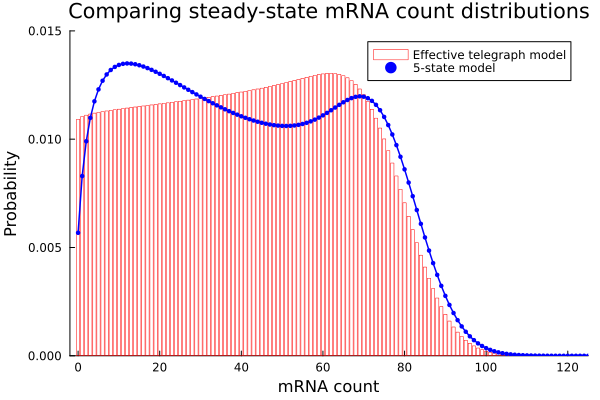

In [20]:
#Plot distributions

mRNA_range = 0:1:m_max_5sm;

bar(mRNA_range, dist_2sm, lc=:red, fillalpha=0, linewidth=0.5, label="Effective telegraph model")
plot!(mRNA_range, dist_5sm, linewidth=1.5, lc=:blue, grid=false, label="")
scatter!(mRNA_range, dist_5sm, ms=2.5, mc=:blue, markerstrokewidth=0, label="5-state model")
xlabel!("mRNA count")
ylabel!("Probability")
title!("Comparing steady-state mRNA count distributions")
xlims!(-2, 125)
ylims!(0.0, 0.015)